# Grad-CAM on MNIST

2019-06-02

This notebook demonstrates the use of Gradient Class-Activation-Map (Grad-CAM) on MNIST datset.

## See:
- https://github.com/fchollet/deep-learning-with-python-notebooks
- [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization (2017)](https://arxiv.org/abs/1610.02391)

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

from keras.models import Model
from keras.models import load_model
from train import prepare_mnist
from keras import backend as K

## Load model

In [3]:
model = load_model('model/mnist_2019-06-02')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_______________________________________

## Check model activations

In [4]:
(x_train, y_train), (x_test, y_test), input_shape = prepare_mnist()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


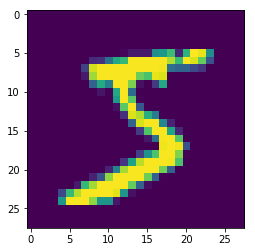

In [5]:
x_train = x_train.squeeze()
test_img = x_train[0]
plt.imshow(test_img)

In [75]:
x_train[0].max()

1.0

In [6]:
# Extract the outputs of the two conv layers
layer_outputs = [layer.output for layer in model.layers[1:3]]
# Create a model returning the layer_outputs for the model input
act_model = Model(inputs=model.input, outputs=layer_outputs)

In [7]:
act_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
Total params: 18,816
Trainable params: 18,816
Non-trainable params: 0
_________________________________________________________________


In [8]:
activations = act_model.predict(test_img.reshape(1,test_img.shape[0],test_img.shape[1],1))

In [9]:
[print(act.shape) for act in activations];

(1, 26, 26, 32)
(1, 24, 24, 64)


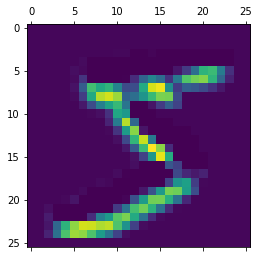

In [10]:
plt.matshow(activations[0][0,:,:,31], cmap='viridis')

In [11]:
# Make grid plots
def plot_conv_layer(which_conv):
    # Plot conv layer activation
    # which_conv = 0 # 0=first, 1=second
    img_per_row = 10
    n_feat = activations[which_conv].shape[-1] # number of feature maps
    size = activations[which_conv].shape[1] # image feature (e.g., 26)
    n_col = np.round(n_feat/img_per_row).astype('int')
    display_grid = np.zeros((size*n_col, img_per_row*size))
    # Add each filter into the grids
    for col in range(n_col):
        for row in range(img_per_row):
            if col*img_per_row+row < size:
                img = activations[which_conv][0,:,:,col*img_per_row+row]
                # Post-process images
                img -= img.mean()
                img -= img.std()
                img *= 64
                img += 128
                img = np.clip(img, 0, 255).astype('uint8')
                display_grid[col*size:(col+1)*size,
                             row*size:(row+1)*size] = img
    scale = 1/size
    fig, ax = plt.subplots(figsize=(scale*display_grid.shape[1], scale*display_grid.shape[0]))
    ax.set_title(f'ConvLayer = {which_conv+1}')
    ax.grid(False)
    ax.imshow(display_grid, aspect='auto', cmap='viridis')
    return fig, ax

(<Figure size 720x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5d5842ebe0>)

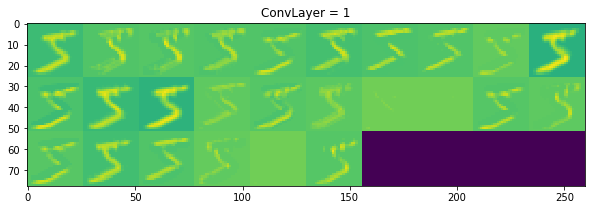

In [12]:
plot_conv_layer(0)

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5d583a1e80>)

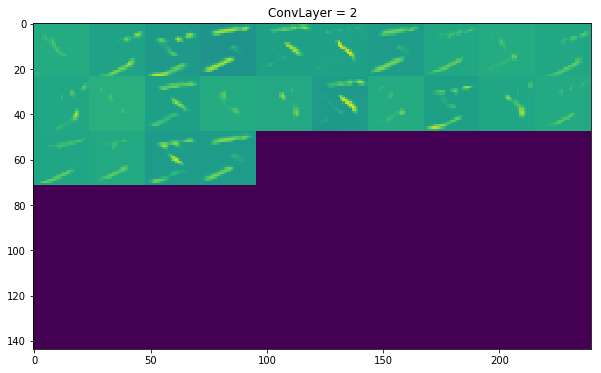

In [13]:
plot_conv_layer(1)

## Visualize Grad-CAM

Grad-CAM visualizes input features that are most likely to generate the target.

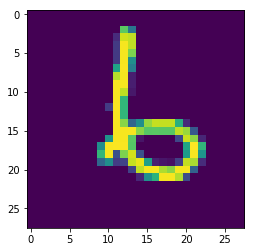

In [54]:
which_number = 6
# Convert ont-hot vector to integer
y_test_int = np.where(y_test==1)[1]
# Randomly select one example
rand_idx = np.random.choice(np.where(y_test_int == which_number)[0])
test_input = x_test[rand_idx].reshape(1,x_test.shape[1],x_test.shape[2],1)
# Visualize test_input
plt.imshow(test_input.squeeze());

In [55]:
# Get output vector
output_vector = model.output[:, which_number]
# Get the last convolutional layer
last_conv_layer = model.layers[2]
# Get the gradient of the given number with regard to the output feature map of the last conv layer
grads = K.gradients(output_vector, last_conv_layer.output)[0] # (None,24,24,64)
# Get the mean intensity of the gradient over each feature map (64)
pooled_grads = K.mean(grads, axis=(0, 1, 2)) # 64
# Compute gradient given an inputw
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([test_input]) # 64, (24,24,64)
# Multiply each channel in the feature map array
# by 'how important this channel is' with regard to the given number
for i in range(len(pooled_grads_value)):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
# Calculate channel-wise mean for the heatmap activation
heatmap = np.mean(conv_layer_output_value, axis=-1)

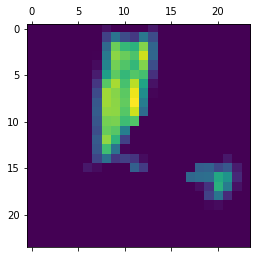

In [56]:
heatmap = np.maximum(heatmap, 0) # => max(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [57]:
# Add 3 channels for coloring the heatmap
img_size = (500, 500)
# Prepare image
test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2BGR) # (500, 500, 3)
test_input_resized *= 255
# Make heatmap
heatmap_resized = cv2.resize(heatmap, img_size) # (500, 500)
heatmap_resized = np.uint8(255*heatmap_resized)
heatmap_resized = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
# Apply heatmap on the original image
superimposed_img = heatmap_resized*0.5 + test_input_resized
# Save
cv2.imwrite('outputs/test.jpg', superimposed_img);

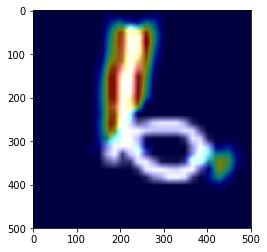

In [58]:
img = mpimg.imread('outputs/test.jpg')
plt.imshow(img)

In [73]:
# # Generate input JPEG files for testing
# for number in range(10):
#     # Convert ont-hot vector to integer
#     y_test_int = np.where(y_test==1)[1]
#     # Randomly select one example
#     rand_idx = np.random.choice(np.where(y_test_int == number)[0])
#     test_input = x_test[rand_idx].reshape(1,x_test.shape[1],x_test.shape[2],1)
#     # Resize
#     img_size = (500, 500)
#     # Prepare image
#     test_input_resized = cv2.resize(test_input.squeeze(), img_size) # (500, 500)
#     test_input_resized = cv2.cvtColor(test_input_resized, cv2.COLOR_GRAY2BGR) # (500, 500, 3)
#     test_input_resized /= test_input_resized.max()
#     test_input_resized *= 255
#     cv2.imwrite(f'examples/{number:02}.jpg', test_input_resized);